In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Import modules
import numpy as np
import holidays
import pandas as pd
import seaborn as sns
import pickle
import time
import timeit
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

import datetime
import math
from collections import Counter

#scipy
import scipy.stats as stats
from scipy import stats
from scipy.stats import chi2_contingency

#sklearn
import sklearn
from sklearn import ensemble
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, precision_score, log_loss, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC

#for clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

#other learners
from lightgbm import LGBMClassifier
#imblearn
from imblearn.ensemble import BalancedBaggingClassifier

#warning ignorer
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

# Classifiers
from sklearn.naive_bayes import MultinomialNB

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported fro

In [3]:
# Reading in pre-processed and transformed data 
file = '/content/drive/MyDrive/Trial/data/Accidents/Visualized_and_manipulated.csv'
df = pd.read_csv(file, low_memory = False)
# Dropping unnamed column
df.drop(df.columns[0],axis=1,inplace=True)
df.head()

,Accident_Index,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Month,Weekend,Hour,Season,accident_seriousness
0,201501BS70008,-0.206022,51.496572,Metropolitan Police,Serious,2,1,2015-01-09,Friday,Morning Rush,Kensington and Chelsea,Kensington and Chelsea,A,Single carriageway,30.0,Crossroads,Auto traffic signal,A,None within 50 metres,Pedestrian phase at traffic signal junction,Daylight,Raining no high winds,Wet or damp,None,None,Urban,No,1,1,7,winter,Severe
1,201501BS70009,-0.193610,51.500788,Metropolitan Police,Slight,2,1,2015-01-15,Thursday,Morning Rush,Kensington and Chelsea,Kensington and Chelsea,A,Single carriageway,30.0,T or staggered junction,Give way or uncontrolled,C,None within 50 metres,"Pelican, puffin, toucan or similar non-junctio...",Daylight,Fine no high winds,Wet or damp,None,None,Urban,Yes,1,0,9,winter,Not Severe
2,201501BS70015,-0.184495,51.501726,Metropolitan Police,Slight,1,2,2015-01-22,Thursday,Morning Rush,Westminster,Westminster,A,Single carriageway,30.0,T or staggered junction,Auto traffic signal,B,None within 50 metres,Pedestrian phase at traffic signal junction,Daylight,Fine no high winds,Dry,None,None,Urban,Yes,1,0,8,winter,Not Severe
3,201501BS70026,-0.163102,51.499864,Metropolitan Police,Serious,1,1,2015-01-23,Friday,Night,Kensington and Chelsea,Kensington and Chelsea,A,Dual carriageway,30.0,T or staggered junction,Give way or uncontrolled,A,None within 50 metres,"Pelican, puffin, toucan or similar non-junctio...",Darkness - lights lit,Raining no high winds,Wet or damp,None,None,Urban,Yes,1,1,23,winter,Severe
4,201501BS70027,-0.192941,51.488548,Metropolitan Police,Slight,1,1,2015-01-20,Tuesday,After Work Rush,Kensington and Chelsea,Kensington and Chelsea,A,Single carriageway,30.0,Crossroads,Auto traffic signal,A,None within 50 metres,Pedestrian phase at traffic signal junction,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,No,1,0,17,winter,Not Severe


In [4]:
#made separate dataframe w. set index that wouldnt effect data vis above
df1=df
#set index to accident_index
df1.set_index('Accident_Index', inplace=True)
df1.head()

,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Month,Weekend,Hour,Season,accident_seriousness
Accident_Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
201501BS70008,-0.206022,51.496572,Metropolitan Police,Serious,2,1,2015-01-09,Friday,Morning Rush,Kensington and Chelsea,Kensington and Chelsea,A,Single carriageway,30.0,Crossroads,Auto traffic signal,A,None within 50 metres,Pedestrian phase at traffic signal junction,Daylight,Raining no high winds,Wet or damp,None,None,Urban,No,1,1,7,winter,Severe
201501BS70009,-0.193610,51.500788,Metropolitan Police,Slight,2,1,2015-01-15,Thursday,Morning Rush,Kensington and Chelsea,Kensington and Chelsea,A,Single carriageway,30.0,T or staggered junction,Give way or uncontrolled,C,None within 50 metres,"Pelican, puffin, toucan or similar non-junctio...",Daylight,Fine no high winds,Wet or damp,None,None,Urban,Yes,1,0,9,winter,Not Severe
201501BS70015,-0.184495,51.501726,Metropolitan Police,Slight,1,2,2015-01-22,Thursday,Morning Rush,Westminster,Westminster,A,Single carriageway,30.0,T or staggered junction,Auto traffic signal,B,None within 50 metres,Pedestrian phase at traffic signal junction,Daylight,Fine no high winds,Dry,None,None,Urban,Yes,1,0,8,winter,Not Severe
201501BS70026,-0.163102,51.499864,Metropolitan Police,Serious,1,1,2015-01-23,Friday,Night,Kensington and Chelsea,Kensington and Chelsea,A,Dual carriageway,30.0,T or staggered junction,Give way or uncontrolled,A,None within 50 metres,"Pelican, puffin, toucan or similar non-junctio...",Darkness - lights lit,Raining no high winds,Wet or damp,None,None,Urban,Yes,1,1,23,winter,Severe
201501BS70027,-0.192941,51.488548,Metropolitan Police,Slight,1,1,2015-01-20,Tuesday,After Work Rush,Kensington and Chelsea,Kensington and Chelsea,A,Single carriageway,30.0,Crossroads,Auto traffic signal,A,None within 50 metres,Pedestrian phase at traffic signal junction,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,No,1,0,17,winter,Not Severe


In [5]:
df1.shape

(95342, 31)

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95342 entries, 201501BS70008 to 2019984107219
Data columns (total 31 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Longitude                                    95342 non-null  float64
 1   Latitude                                     95342 non-null  float64
 2   Police_Force                                 95342 non-null  object 
 3   Accident_Severity                            95342 non-null  object 
 4   Number_of_Vehicles                           95342 non-null  object 
 5   Number_of_Casualties                         95342 non-null  object 
 6   Date                                         95342 non-null  object 
 7   Day_of_Week                                  95342 non-null  object 
 8   Time                                         95342 non-null  object 
 9   Local_Authority_(District)                   95342 non-nu

In [7]:
#create a new target variable - Reduced target class from a multi-class classification to a binary classification 
# problem to handle the imbalanced dataset and simplify analysis
 

df1.loc[df1.Accident_Severity !='Slight', 'Target_Severe_Indicator'] = 1
df1.loc[df1.Accident_Severity =='Slight', 'Target_Severe_Indicator'] = 0

In [8]:
df1["Target_Severe_Indicator"].value_counts()


0.0    81220
1.0    14122
Name: Target_Severe_Indicator, dtype: int64

In [9]:
df1["Accident_Severity"].value_counts()

Slight     81220
Serious    13352
Fatal        770
Name: Accident_Severity, dtype: int64

In [10]:
df1.head()

,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Month,Weekend,Hour,Season,accident_seriousness,Target_Severe_Indicator
Accident_Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
201501BS70008,-0.206022,51.496572,Metropolitan Police,Serious,2,1,2015-01-09,Friday,Morning Rush,Kensington and Chelsea,Kensington and Chelsea,A,Single carriageway,30.0,Crossroads,Auto traffic signal,A,None within 50 metres,Pedestrian phase at traffic signal junction,Daylight,Raining no high winds,Wet or damp,None,None,Urban,No,1,1,7,winter,Severe,1.0
201501BS70009,-0.193610,51.500788,Metropolitan Police,Slight,2,1,2015-01-15,Thursday,Morning Rush,Kensington and Chelsea,Kensington and Chelsea,A,Single carriageway,30.0,T or staggered junction,Give way or uncontrolled,C,None within 50 metres,"Pelican, puffin, toucan or similar non-junctio...",Daylight,Fine no high winds,Wet or damp,None,None,Urban,Yes,1,0,9,winter,Not Severe,0.0
201501BS70015,-0.184495,51.501726,Metropolitan Police,Slight,1,2,2015-01-22,Thursday,Morning Rush,Westminster,Westminster,A,Single carriageway,30.0,T or staggered junction,Auto traffic signal,B,None within 50 metres,Pedestrian phase at traffic signal junction,Daylight,Fine no high winds,Dry,None,None,Urban,Yes,1,0,8,winter,Not Severe,0.0
201501BS70026,-0.163102,51.499864,Metropolitan Police,Serious,1,1,2015-01-23,Friday,Night,Kensington and Chelsea,Kensington and Chelsea,A,Dual carriageway,30.0,T or staggered junction,Give way or uncontrolled,A,None within 50 metres,"Pelican, puffin, toucan or similar non-junctio...",Darkness - lights lit,Raining no high winds,Wet or damp,None,None,Urban,Yes,1,1,23,winter,Severe,1.0
201501BS70027,-0.192941,51.488548,Metropolitan Police,Slight,1,1,2015-01-20,Tuesday,After Work Rush,Kensington and Chelsea,Kensington and Chelsea,A,Single carriageway,30.0,Crossroads,Auto traffic signal,A,None within 50 metres,Pedestrian phase at traffic signal junction,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,No,1,0,17,winter,Not Severe,0.0


In [11]:
print(df1.columns)

Index(['Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', 'Road_Type', 'Speed_limit', 'Junction_Detail',
       'Junction_Control', '2nd_Road_Class',
       'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'Month', 'Weekend', 'Hour', 'Season', 'accident_seriousness',
       'Target_Severe_Indicator'],
      dtype='object')


In [12]:
for col in set(df1.columns) - set(df1.describe().columns):
    df1[col] = df1[col].astype('category')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95342 entries, 201501BS70008 to 2019984107219
Data columns (total 32 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   Longitude                                    95342 non-null  float64 
 1   Latitude                                     95342 non-null  float64 
 2   Police_Force                                 95342 non-null  category
 3   Accident_Severity                            95342 non-null  category
 4   Number_of_Vehicles                           95342 non-null  category
 5   Number_of_Casualties                         95342 non-null  category
 6   Date                                         95342 non-null  category
 7   Day_of_Week                                  95342 non-null  category
 8   Time                                         95342 non-null  category
 9   Local_Authority_(District)                   9

In [14]:
np.random.seed(150)

remove_n = 85342 #Sample size to remove from original dataset
df = df1
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df_subset = df.drop(drop_indices)

In [15]:
df_subset.shape
df_subset.head()

,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Month,Weekend,Hour,Season,accident_seriousness,Target_Severe_Indicator
Accident_Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
201501BS70033,-0.185515,51.483307,Metropolitan Police,Slight,2,2,2015-01-30,Friday,Night,Kensington and Chelsea,Kensington and Chelsea,A,Single carriageway,30.0,Crossroads,Auto traffic signal,A,None within 50 metres,Pedestrian phase at traffic signal junction,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,Yes,1,1,1,winter,Not Severe,0.0
201501BS70087,-0.190458,51.489409,Metropolitan Police,Slight,1,2,2015-02-20,Friday,Night,Kensington and Chelsea,Kensington and Chelsea,A,Single carriageway,30.0,Crossroads,Auto traffic signal,A,None within 50 metres,Pedestrian phase at traffic signal junction,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,Yes,2,1,23,winter,Not Severe,0.0
201501BS70142,-0.194273,51.509521,Metropolitan Police,Slight,2,2,2015-03-23,Monday,Morning Rush,Kensington and Chelsea,Kensington and Chelsea,A,Single carriageway,30.0,Crossroads,Auto traffic signal,A,None within 50 metres,Pedestrian phase at traffic signal junction,Daylight,Fine no high winds,Dry,None,None,Urban,Yes,3,0,8,spring,Not Severe,0.0
201501BS70193,-0.184191,51.484006,Metropolitan Police,Slight,1,1,2015-01-06,Tuesday,Evening,Kensington and Chelsea,Kensington and Chelsea,A,Single carriageway,30.0,Crossroads,Auto traffic signal,A,None within 50 metres,Pedestrian phase at traffic signal junction,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,Yes,1,0,18,winter,Not Severe,0.0
201501BS70198,-0.215898,51.527746,Metropolitan Police,Serious,2,1,2015-04-17,Friday,Night,Westminster,Westminster,A,Single carriageway,30.0,Crossroads,Auto traffic signal,B,None within 50 metres,Pedestrian phase at traffic signal junction,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,Yes,4,1,23,spring,Severe,1.0


In [16]:
# 85% to 15% distribution of target class - Proportionality of the original dataset is still maintained
df_subset['Target_Severe_Indicator'].value_counts()

0.0    8511
1.0    1489
Name: Target_Severe_Indicator, dtype: int64

In [17]:
df_X = df_subset.drop('Target_Severe_Indicator', axis=1)  
df_Y = df_subset['Target_Severe_Indicator']  

In [18]:
# Converting independent categorical features to Numerical by creating Dummy variables

df_X_dummy = pd.get_dummies(df_X)
#print(dataset_X_dummy.head())

In [19]:
df_X_dummy.shape

(10000, 2576)

In [20]:
from sklearn.feature_selection import VarianceThreshold

# threshold set to 87% for variance 
# i.e. if 87% of the column data is the same (i.e. low variation), the column will not be as useful
# in the prediction
thresh=(.85 * (1 - .85))

In [21]:
# Wrapper function to identify low variance features and remove them from the dataframe 

def get_low_variance_columns(dframe=None, columns=None,
                             skip_columns=None, thresh=0.0,
                             autoremove=False):
    try:
        # get list of all the original df columns
        all_columns = dframe.columns

        # remove `skip_columns`
        remaining_columns = all_columns.drop(skip_columns)

        # get length of new index
        max_index = len(remaining_columns) - 1

        # get indices for `skip_columns`
        skipped_idx = [all_columns.get_loc(column)
                       for column
                       in skip_columns]

        # adjust insert location by the number of columns removed
        # (for non-zero insertion locations) to keep relative
        # locations intact
        for idx, item in enumerate(skipped_idx):
            if item > max_index:
                diff = item - max_index
                skipped_idx[idx] -= diff
            if item == max_index:
                diff = item - len(skip_columns)
                skipped_idx[idx] -= diff
            if idx == 0:
                skipped_idx[idx] = item

        # get values of `skip_columns`
        skipped_values = dframe.iloc[:, skipped_idx].values

        # get dataframe values
        X = dframe.loc[:, remaining_columns].values

        # instantiate VarianceThreshold object
        vt = VarianceThreshold(threshold=thresh)

        # fit vt to data
        vt.fit(X)

        # get the indices of the features that are being kept
        feature_indices = vt.get_support(indices=True)

        # remove low-variance columns from index
        feature_names = [remaining_columns[idx]
                         for idx, _
                         in enumerate(remaining_columns)
                         if idx
                         in feature_indices]

        # get the columns to be removed
        removed_features = list(np.setdiff1d(remaining_columns,
                                             feature_names))
        print("Found {0} low-variance columns."
              .format(len(removed_features)))

        # remove the columns
        if autoremove:
            print("Removing low-variance features.")
            # remove the low-variance columns
            X_removed = vt.transform(X)

            print("Reassembling the dataframe (with low-variance "
                  "features removed).")
            # re-assemble the dataframe
            dframe = pd.DataFrame(data=X_removed,
                                  columns=feature_names)

            # add back the `skip_columns`
            for idx, index in enumerate(skipped_idx):
                dframe.insert(loc=index,
                              column=skip_columns[idx],
                              value=skipped_values[:, idx])
            print("Succesfully removed low-variance columns.")

        # do not remove columns
        else:
            print("No changes have been made to the dataframe.")

    except Exception as e:
        print(e)
        print("Could not remove low-variance features. Something "
              "went wrong.")
        pass

    return dframe, removed_features

In [22]:
# retrieve new dataframe (with low variance features)
df_X_new, low_var_col = get_low_variance_columns(df_X_dummy,[],[],thresh, True) 
#Set to True to remove low variance columns

Found 2534 low-variance columns.
Removing low-variance features.
Reassembling the dataframe (with low-variance features removed).
Succesfully removed low-variance columns.


In [23]:
df_X_new.shape

(10000, 42)

In [24]:
df_X_new.head()

,Longitude,Latitude,Speed_limit,Month,Weekend,Hour,Police_Force_Metropolitan Police,Number_of_Vehicles_1,Number_of_Vehicles_2,Number_of_Casualties_1,Number_of_Casualties_2,Day_of_Week_Friday,Day_of_Week_Wednesday,Time_After Work Rush,Time_Evening,Time_Morning Rush,1st_Road_Class_A,Road_Type_Dual carriageway,Road_Type_Roundabout,Road_Type_Single carriageway,Junction_Detail_Crossroads,Junction_Detail_Roundabout,Junction_Detail_T or staggered junction,Junction_Control_Auto traffic signal,Junction_Control_Give way or uncontrolled,2nd_Road_Class_A,2nd_Road_Class_B,2nd_Road_Class_C,Pedestrian_Crossing-Physical_Facilities_No physical crossing facilities within 50 metres,Pedestrian_Crossing-Physical_Facilities_Pedestrian phase at traffic signal junction,Light_Conditions_Darkness - lights lit,Light_Conditions_Daylight,Road_Surface_Conditions_Dry,Road_Surface_Conditions_Wet or damp,Urban_or_Rural_Area_Rural,Urban_or_Rural_Area_Urban,Did_Police_Officer_Attend_Scene_of_Accident_No,Did_Police_Officer_Attend_Scene_of_Accident_Yes,Season_fall,Season_spring,Season_summer,Season_winter
0,-0.185515,51.483307,30.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.190458,51.489409,30.0,2.0,1.0,23.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.194273,51.509521,30.0,3.0,0.0,8.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,-0.184191,51.484006,30.0,1.0,0.0,18.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.215898,51.527746,30.0,4.0,1.0,23.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [25]:
df_X_normalized=(df_X_new-df_X_new.min())/(df_X_new.max()-df_X_new.min())

In [26]:
df_X_normalized.head()

,Longitude,Latitude,Speed_limit,Month,Weekend,Hour,Police_Force_Metropolitan Police,Number_of_Vehicles_1,Number_of_Vehicles_2,Number_of_Casualties_1,Number_of_Casualties_2,Day_of_Week_Friday,Day_of_Week_Wednesday,Time_After Work Rush,Time_Evening,Time_Morning Rush,1st_Road_Class_A,Road_Type_Dual carriageway,Road_Type_Roundabout,Road_Type_Single carriageway,Junction_Detail_Crossroads,Junction_Detail_Roundabout,Junction_Detail_T or staggered junction,Junction_Control_Auto traffic signal,Junction_Control_Give way or uncontrolled,2nd_Road_Class_A,2nd_Road_Class_B,2nd_Road_Class_C,Pedestrian_Crossing-Physical_Facilities_No physical crossing facilities within 50 metres,Pedestrian_Crossing-Physical_Facilities_Pedestrian phase at traffic signal junction,Light_Conditions_Darkness - lights lit,Light_Conditions_Daylight,Road_Surface_Conditions_Dry,Road_Surface_Conditions_Wet or damp,Urban_or_Rural_Area_Rural,Urban_or_Rural_Area_Urban,Did_Police_Officer_Attend_Scene_of_Accident_No,Did_Police_Officer_Attend_Scene_of_Accident_Yes,Season_fall,Season_spring,Season_summer,Season_winter
0,0.773444,0.157348,0.2,0.000000,1.0,0.043478,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.772867,0.158036,0.2,0.090909,1.0,1.000000,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.772421,0.160304,0.2,0.181818,0.0,0.347826,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.773599,0.157427,0.2,0.000000,0.0,0.782609,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.769896,0.162360,0.2,0.272727,1.0,1.000000,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [27]:
df_X=df_X_normalized.round(3) 

In [28]:
df_X.head(3)

,Longitude,Latitude,Speed_limit,Month,Weekend,Hour,Police_Force_Metropolitan Police,Number_of_Vehicles_1,Number_of_Vehicles_2,Number_of_Casualties_1,Number_of_Casualties_2,Day_of_Week_Friday,Day_of_Week_Wednesday,Time_After Work Rush,Time_Evening,Time_Morning Rush,1st_Road_Class_A,Road_Type_Dual carriageway,Road_Type_Roundabout,Road_Type_Single carriageway,Junction_Detail_Crossroads,Junction_Detail_Roundabout,Junction_Detail_T or staggered junction,Junction_Control_Auto traffic signal,Junction_Control_Give way or uncontrolled,2nd_Road_Class_A,2nd_Road_Class_B,2nd_Road_Class_C,Pedestrian_Crossing-Physical_Facilities_No physical crossing facilities within 50 metres,Pedestrian_Crossing-Physical_Facilities_Pedestrian phase at traffic signal junction,Light_Conditions_Darkness - lights lit,Light_Conditions_Daylight,Road_Surface_Conditions_Dry,Road_Surface_Conditions_Wet or damp,Urban_or_Rural_Area_Rural,Urban_or_Rural_Area_Urban,Did_Police_Officer_Attend_Scene_of_Accident_No,Did_Police_Officer_Attend_Scene_of_Accident_Yes,Season_fall,Season_spring,Season_summer,Season_winter
0,0.773,0.157,0.2,0.000,1.0,0.043,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.773,0.158,0.2,0.091,1.0,1.000,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.772,0.160,0.2,0.182,0.0,0.348,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [29]:
df_Y.value_counts()

0.0    8511
1.0    1489
Name: Target_Severe_Indicator, dtype: int64

In [30]:
#confusion matrix plot function
def cm_plot(var):
    plt.figure(figsize=(15,5))
    plt.style.use('dark_background')
    plt.clf()
    plt.imshow(var, interpolation='nearest', cmap='tab20')
    classNames = ['No Loyalty','Loyalty']
    plt.title('Confusion Matrix')
    plt.ylabel('Actual\n')
    plt.xlabel('Predicted\n')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+"="+str(var[i][j]),horizontalalignment='center', 
                     color='black')
    plt.show()

In [31]:
# Undersampling and Oversampling for class imbalance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [32]:
# Undersamples variation
# ----------------------

# Generate variation
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_sample(df_X, df_Y)
undersampled = pd.DataFrame(X_under, columns=df_X.columns)
undersampled['Target_Severe_Indicator'] = y_under
undersampled.to_csv('/content/drive/MyDrive/Trial/data/Accidents/undersampled_ohe.csv', index=False)

In [33]:
# Load variation
undersampled = pd.read_csv('/content/drive/MyDrive/Trial/data/Accidents/undersampled_ohe.csv', keep_default_na=False)
y_under = undersampled['Target_Severe_Indicator']
X_under = undersampled.drop('Target_Severe_Indicator', axis=1)

In [34]:
# -----------------------------------------------------------------

X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under,test_size=.2,
                                                                            random_state=42)

# Print class frequencies for variation
pd.Series(y_under).value_counts()

1.0    1489
0.0    1489
Name: Target_Severe_Indicator, dtype: int64

In [35]:
plt.style.use('dark_background')





RandomForestClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 60.2349%
Cross validation scores: 0.5852225020990764


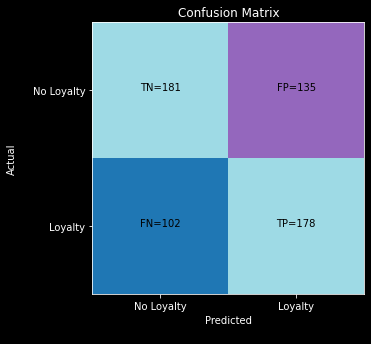





LGBMClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 61.5772%
Cross validation scores: 0.5839630562552477


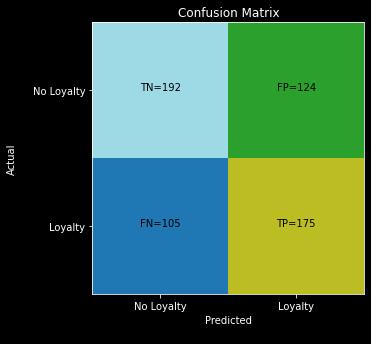

****************************************


In [36]:
#Try modeling using  different classification models
classifiers = [
    RandomForestClassifier(criterion='entropy', max_depth=40,max_features=df_X.shape[1], 
                           min_samples_split=8, n_estimators=500, random_state=42),
    LGBMClassifier(learning_rate =0.03, max_depth=40, min_data_in_leaf=10,
                   n_estimators=500, num_leaves=50, random_state = 42)]
    
#putting results in df
res_cols=["Classifier", "Accuracy","precision", "Recall", "Roc Auc",]
results = pd.DataFrame(columns=res_cols)

for clf in classifiers:
    clf.fit(X_train_under, y_train_under)
    name = clf.__class__.__name__
    
    print("\n"*3)
    print(name,"Results:")
       
    print('~'*40)
    y_pred = clf.predict(X_test_under)
    acc = accuracy_score(y_test_under, y_pred)
    print("Accuracy: {:.4%}".format(acc))
    
    cv= np.mean(cross_val_score(clf, X_train_under, y_train_under, cv=3))
    print("Cross validation scores:",cv)
    
    
    train_predictions = clf.predict_proba(X_test_under)
   
    cm = confusion_matrix(y_test_under , y_pred)
    
    cm_plot(cm)
    
    #FPR and Error Rate setup
    tn, fp, fn, tp = confusion_matrix(y_test_under ,y_pred).ravel()
    
    fpr = fp/(tn+fp)
    ers = 1-acc
    rec= recall_score(y_test_under, y_pred)
    roc=roc_auc_score(y_test_under, y_pred)
    precision= precision_score(y_test_under, y_pred)
    f1s=f1_score(y_test_under, y_pred)
    results_final = pd.DataFrame([[name, round(acc*100,3),round(precision*100,3), round(rec*100,3), round(roc*100,3),]],
                                 columns=res_cols)
    results = results.append(results_final)
    
print("*"*40)

In [37]:
print("Results Shape",results.shape)
results.head(10)

Results Shape (2, 5)


,Classifier,Accuracy,precision,Recall,Roc Auc
0,RandomForestClassifier,60.235,56.869,63.571,60.425
0,LGBMClassifier,61.577,58.528,62.500,61.630
